In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234)

In [3]:
#loading the training Data

X_train = pd.read_csv('../../Data/X_train.csv')
y_train = pd.read_csv('../../Data/y_train.csv')

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

X_train: (400, 9)
y_train: (400, 1)


In [8]:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical features: {categorical_features}")

drop_cols = []
if 'User_ID' in categorical_features:
    categorical_features.remove('User_ID')
    drop_cols.append('User_ID')

numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features),
        ('drop', 'drop', drop_cols),
        ('numerical', StandardScaler(), numerical_features)
    ]
)


Categorical features: ['User_ID', 'Gender', 'Social_Media_Platform']


I made the preprocssing steps into a single function to be able to apply them into a pipeline to avoid data leakage.

In [9]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svr', SVR())
])

param_grid = {
    'svr__kernel': ['linear', 'rbf', 'poly'],
    'svr__C': [0.1, 1, 10]
}

cv = KFold(n_splits=5, shuffle=True, random_state=1234)

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV MSE: {-grid_search.best_score_}")

best_svr = grid_search.best_estimator_

y_pred_train = best_svr.predict(X_train)

print(f"Training MSE: {mean_squared_error(y_train, y_pred_train)}")
print(f"Training R2: {r2_score(y_train, y_pred_train)}")

Best parameters: {'svr__C': 0.1, 'svr__kernel': 'linear'}
Best CV MSE: 0.9016874587931294
Training MSE: 0.8544205788567817
Training R2: 0.6409054567452455


I made the pipeline combining the preprocessing steps with the svr to be able to apply it directly in the cross validation. Applied it within the cross vaildidation and identified the best model as well as the scoring. 

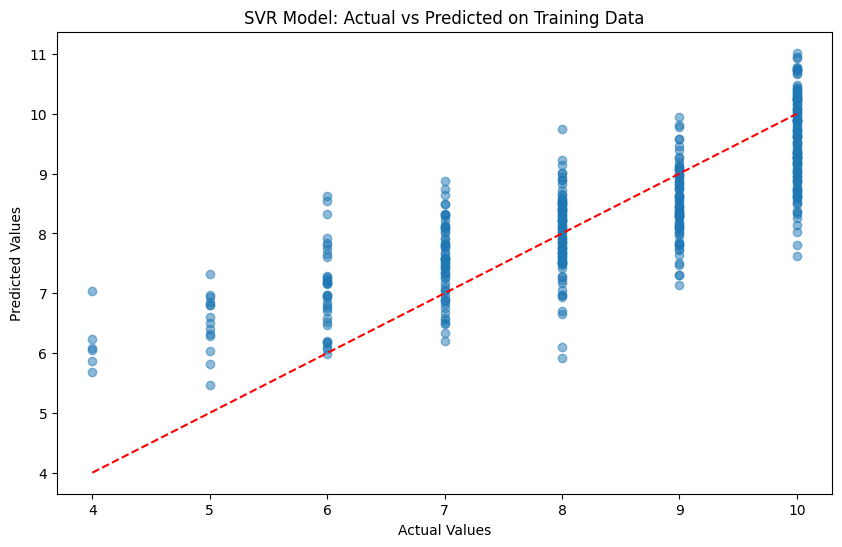

In [10]:
plt.figure(figsize=(10,6))
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("SVR Model: Actual vs Predicted on Training Data")
plt.savefig('../../Outputs/svr_actual_vs_predicted_train.png', dpi=300, bbox_inches='tight')
plt.show()
